In [3]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

In [7]:
# Read in data and display first 5 lines
df = pd.read_csv('/mnt/d/PPRV_LINEAGE_IV/data/stratified_proximity_data.csv')
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   experiment                  64 non-null     int64  
 1   duration                    64 non-null     int64  
 2   seeder                      64 non-null     int64  
 3   Cap2                        64 non-null     int64  
 4   time_between_0.05_and_0.5m  64 non-null     float64
 5   time_between_0.5_and_1m     64 non-null     float64
 6   time_between_1_and_2m       64 non-null     float64
 7   time_above_2m               64 non-null     float64
 8   infected                    64 non-null     int64  
dtypes: float64(4), int64(5)
memory usage: 4.6 KB


(None,
    experiment  duration  seeder  Cap2  time_between_0.05_and_0.5m  \
 0           1         1     436   100                    2.783333   
 1           1         1     436   116                    4.500000   
 2           1         1     436   255                    6.200000   
 3           1         1     436   449                   17.016667   
 4           1         1     436  3008                    0.183333   
 
    time_between_0.5_and_1m  time_between_1_and_2m  time_above_2m  infected  
 0                10.600000              23.483333      25.850000         0  
 1                20.983333              23.216667      13.916667         0  
 2                20.900000              27.200000       8.416667         0  
 3                20.733333              15.933333       9.050000         0  
 4                 1.033333               9.700000      51.816667         0  )

In [8]:
features = ['duration', 'time_between_0.05_and_0.5m', 'time_between_0.5_and_1m', 
            'time_between_1_and_2m', 'time_above_2m']

X = df[features]

In [10]:
# Step 1: Prepare the data (as before)

y = df['infected']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
sample_weights = np.ones_like(y, dtype=float)
sample_weights[y == 0] = class_weights[0]
sample_weights[y == 1] = class_weights[1]

In [25]:
# Step 3: Implement the Bayesian Logistic Regression model with class weighting
with pm.Model() as weighted_model:
    # Priors for unknown model parameters
    intercept = pm.Normal('intercept', mu=0, sigma=10)
    betas = pm.Normal('betas', mu=0, sigma=10, shape=X_scaled.shape[1])
    
    # Expected value of outcome
    mu = intercept + pm.math.dot(X_scaled, betas)

    mu_var = pm.Deterministic('mu_var', mu)
    
    # Likelihood (sampling distribution) of observations with class weighting
    y_obs = pm.Bernoulli('y_obs', logit_p=mu, observed=y, total_size=int(np.sum(sample_weights)))
    
    # Inference
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, betas]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.


In [27]:
# Steps 4-6: Analyze results, make predictions, and evaluate the model (as before)
summary = az.summary(trace, var_names=['intercept', 'betas'])
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-1.934,0.499,-2.826,-0.992,0.007,0.005,5797.0,4790.0,1.0
betas[0],1.925,1.247,-0.257,4.422,0.020,0.014,3832.0,3442.0,1.0
betas[1],-0.604,0.829,-2.188,0.931,0.013,0.010,3987.0,4192.0,1.0
betas[2],0.448,0.977,-1.472,2.232,0.016,0.012,3959.0,3814.0,1.0
betas[3],-0.211,0.560,-1.258,0.847,0.008,0.006,4828.0,4874.0,1.0
betas[4],0.138,1.021,-1.735,2.093,0.016,0.013,4412.0,3214.0,1.0


In [28]:
with weighted_model:
    # For newer PyMC versions
    try:
        post_pred = pm.sample_posterior_predictive(trace, extend_inferencedata=True)
        y_pred_proba = post_pred.posterior_predictive['y_obs'].mean(dim=('chain', 'draw')).values
    # For older PyMC versions
    except TypeError:
        post_pred = pm.sample_posterior_predictive(trace, 500)
        y_pred_proba = post_pred['y_obs'].mean(axis=0)


Sampling: [y_obs]


Output()

ROC AUC: 0.848
PR AUC: 0.682
Brier Score: 0.125


/home/manalitta/miniforge3/envs/pymc_env/lib/python3.10/site-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (70) in plot_posterior, generating only 40 plots
  warnings.warn(


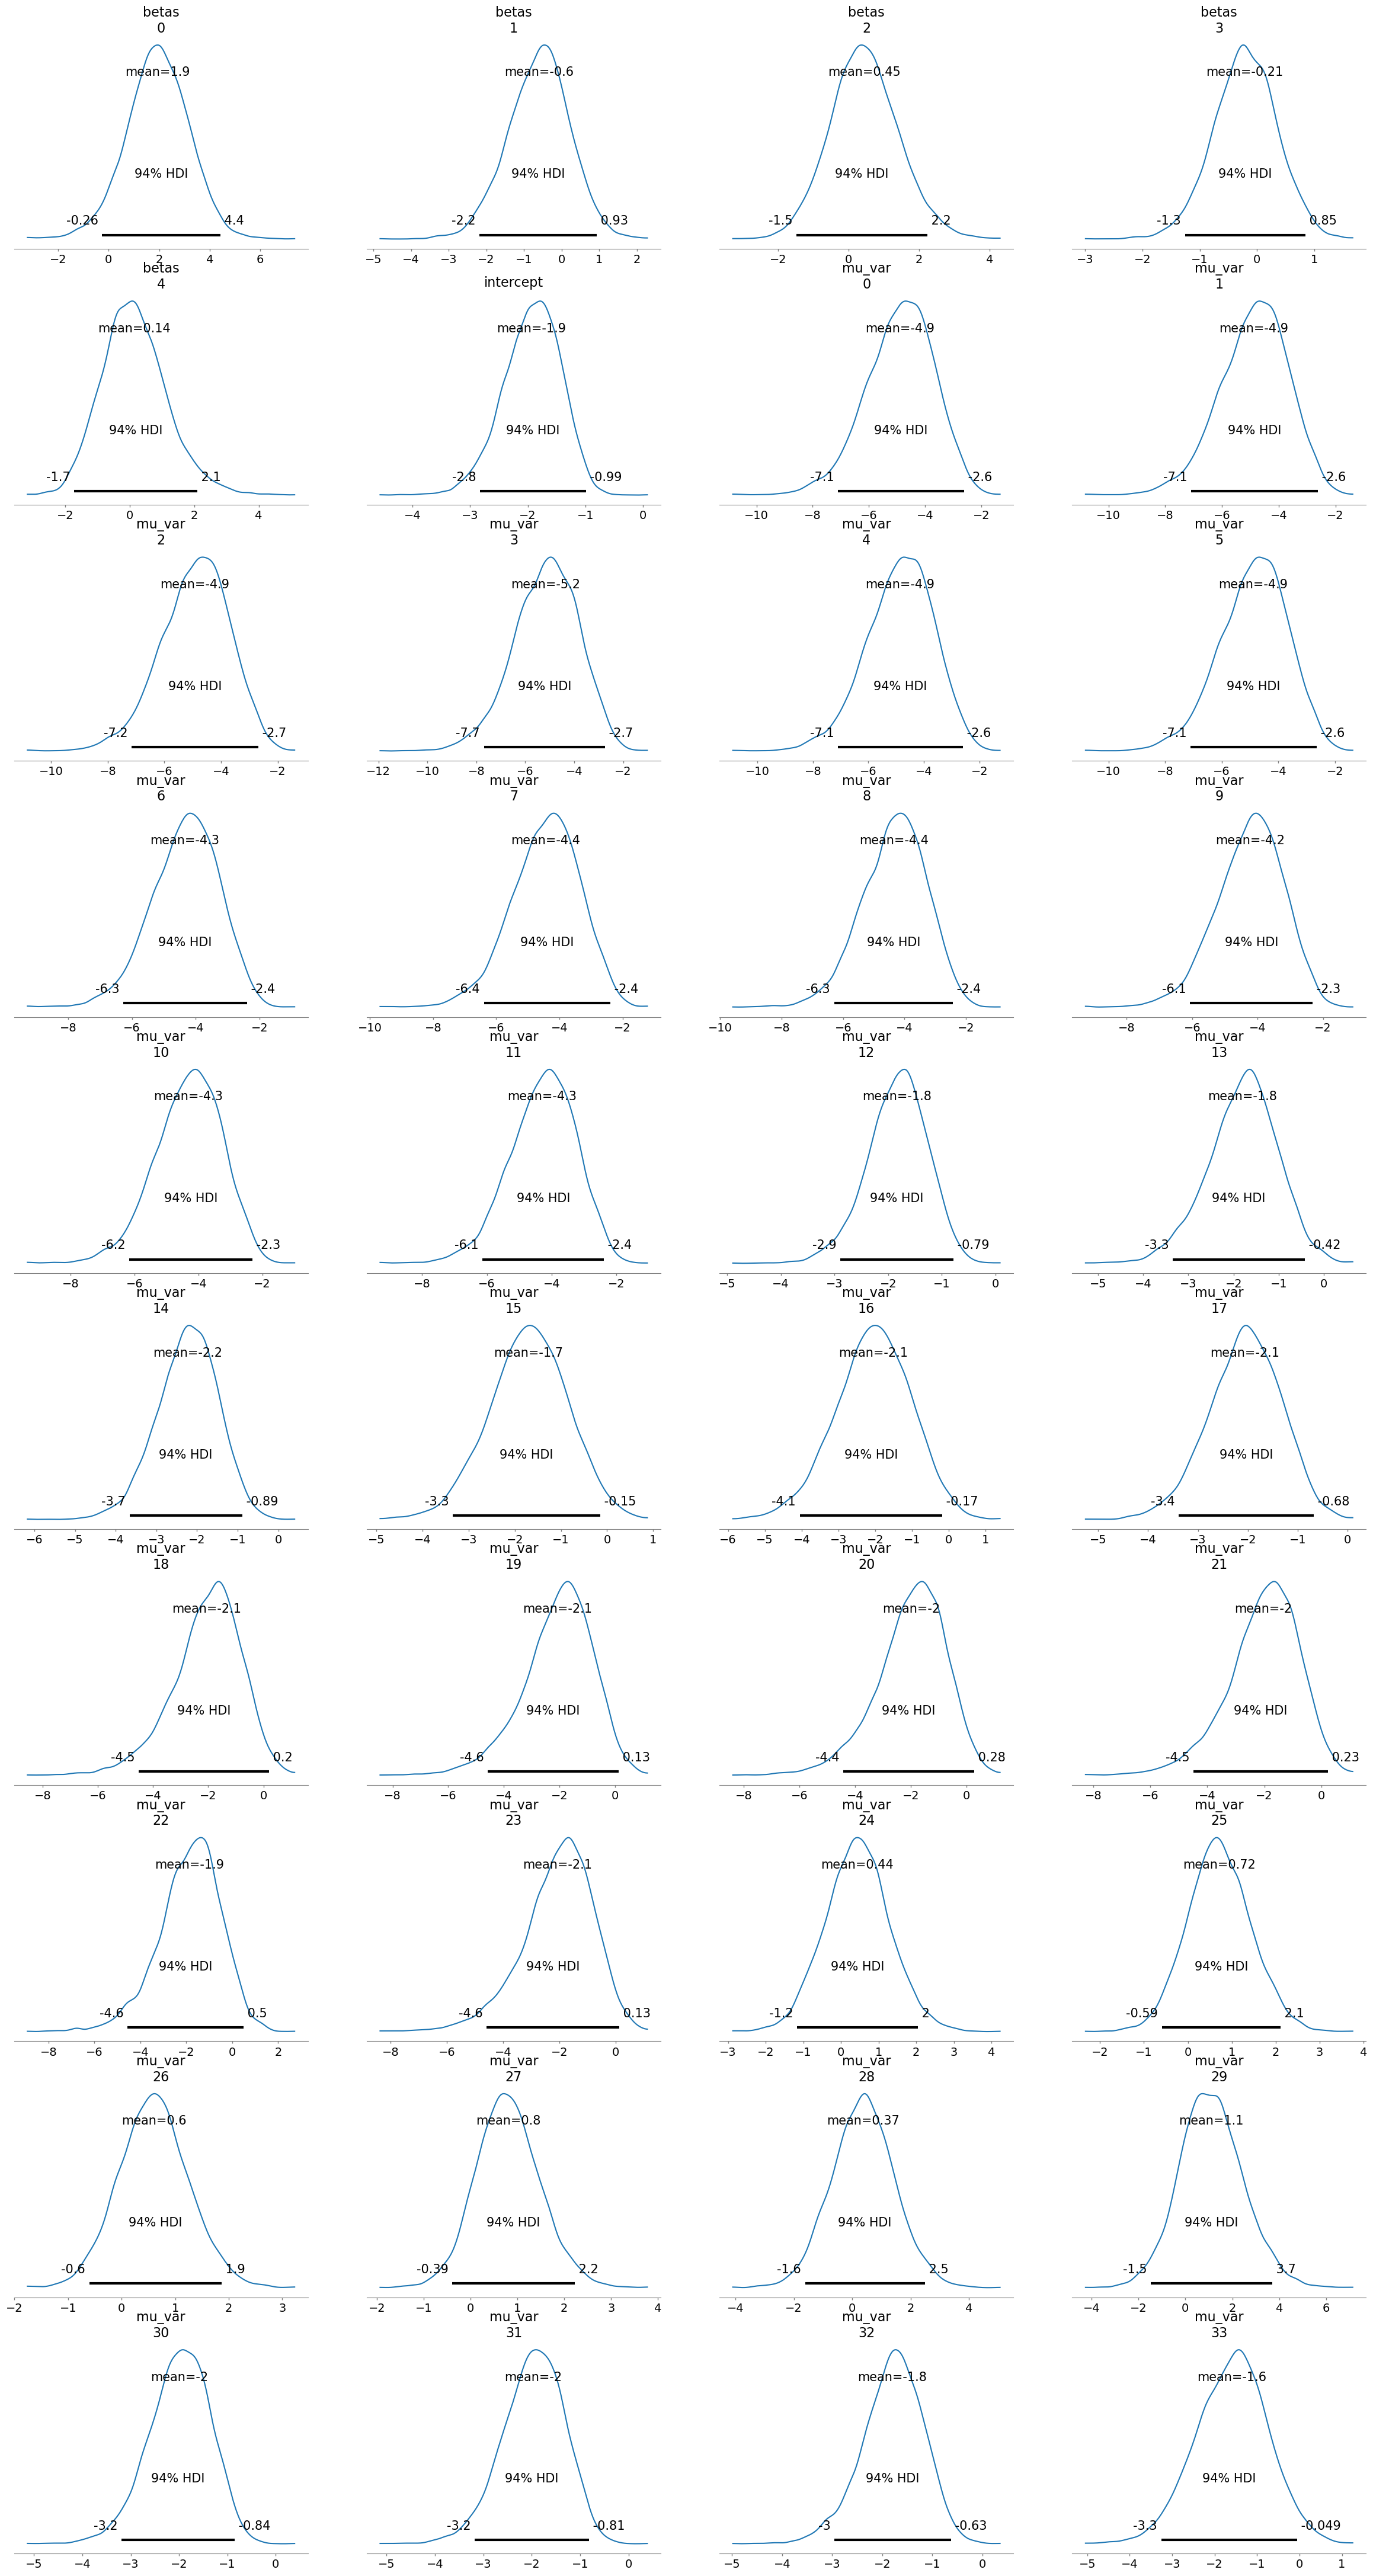

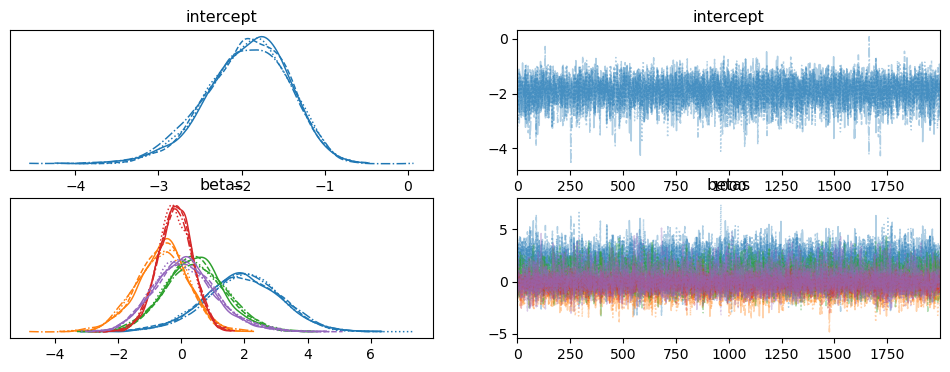

In [30]:
# Step 5: Evaluate the model
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

print(f"ROC AUC: {roc_auc_score(y, y_pred_proba):.3f}")
print(f"PR AUC: {average_precision_score(y, y_pred_proba):.3f}")
print(f"Brier Score: {brier_score_loss(y, y_pred_proba):.3f}")

# Step 6: Visualize the results
import matplotlib.pyplot as plt

az.plot_posterior(trace)
plt.show()

az.plot_trace(trace, var_names=['intercept', 'betas'])
plt.show()

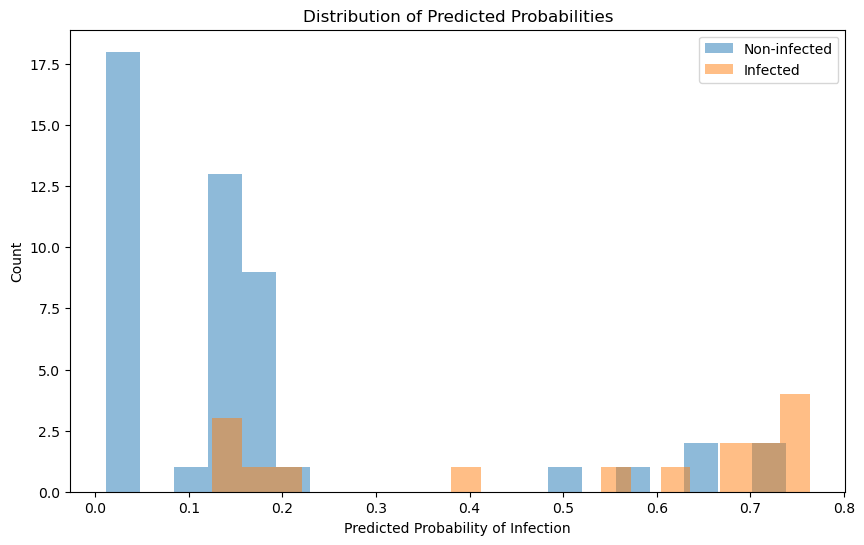

In [31]:
plt.figure(figsize=(10, 6))
plt.hist(y_pred_proba[y == 0], bins=20, alpha=0.5, label='Non-infected')
plt.hist(y_pred_proba[y == 1], bins=20, alpha=0.5, label='Infected')
plt.xlabel('Predicted Probability of Infection')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Predicted Probabilities')
plt.show()

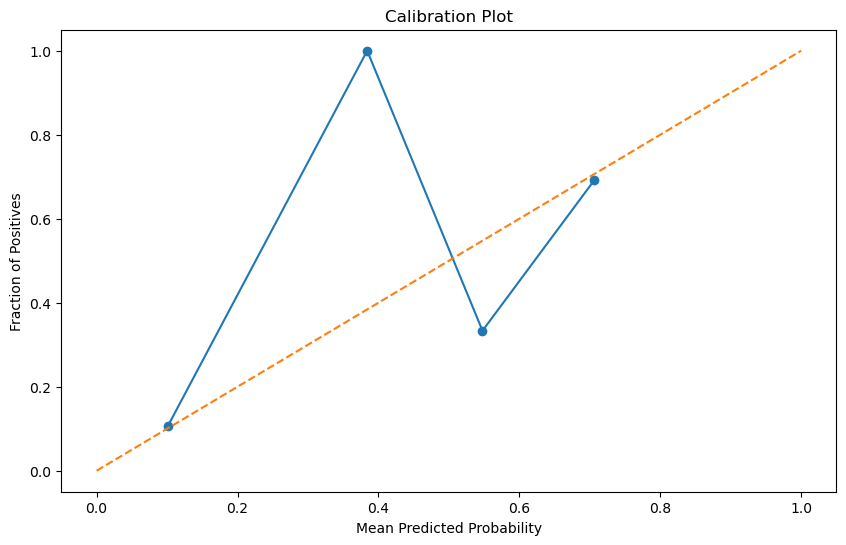

In [32]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y, y_pred_proba, n_bins=5)

plt.figure(figsize=(10, 6))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.show()

In [34]:
with weighted_model:
    mu_samples = trace.posterior['mu_var'].values

In [50]:
len(mu_samples)

4

In [36]:
probabilities = 1 / (1 + np.exp(-mu_samples))
probabilities

array([[[0.00160838, 0.00164289, 0.0015548 , ..., 0.00305026,
         0.00421865, 0.00502512],
        [0.03550486, 0.03412852, 0.03278618, ..., 0.05264302,
         0.03988092, 0.06017094],
        [0.00827872, 0.00850317, 0.00853766, ..., 0.01697087,
         0.02228453, 0.01783678],
        ...,
        [0.00410899, 0.00414628, 0.00380388, ..., 0.00635242,
         0.00925396, 0.01157396],
        [0.00339705, 0.00337553, 0.003319  , ..., 0.00962742,
         0.01001163, 0.01010175],
        [0.02024363, 0.02197274, 0.02158053, ..., 0.03534243,
         0.08865031, 0.05027332]],

       [[0.00753248, 0.00705418, 0.00686261, ..., 0.01514506,
         0.00799043, 0.01517043],
        [0.00016845, 0.00014799, 0.00016715, ..., 0.00171653,
         0.00027082, 0.00053943],
        [0.00140435, 0.00125561, 0.00141964, ..., 0.0081329 ,
         0.00161358, 0.00258901],
        ...,
        [0.0204292 , 0.01855644, 0.01950465, ..., 0.06424482,
         0.02033201, 0.03432234],
        [0.0

In [49]:
len(probabilities), probabilities.shape 

(4, (4, 2000, 64))